In [1]:
# Importing the required libraries:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import os
import cv2
import skimage

import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline 

# Ignore harmless warnings:

import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import platform
print(torch.__version__)
print(platform.python_version())

1.1.0
3.6.10


In [2]:
torch.cuda.get_device_name(0)

'TITAN X (Pascal)'

In [3]:
train_set = ['hola', 'urjc', 'gavab', 'estoril', 'alvaro', 'victoria', 'jose', 'fuengirola'] * 512
val_set = ['hola', 'urjc', 'gavab', 'estoril', 'alvaro', 'victoria', 'jose', 'fuengirola'] * 64

len_train = len(train_set)
len_val = len(val_set)

In [4]:
# Function to convert letters (and therefore words) into PyTorch tensors:

letters = ['SOS_token', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k',
          'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'EOS_token']

def letter_to_vector(letter):
    vector = torch.zeros(1, 1, len(letters))
    for i in range(len(letters)):
        if letters[i] == letter:
            vector[0, 0, i] = 1.
    return(vector)

print(letter_to_vector('SOS_token'))

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])


In [5]:
def patch_gen(word, n_patches, patch_height, patch_width, stepsize):
    
    image = 255 * np.ones(shape = [height, width], dtype = np.uint8)
    image = cv2.putText(image, text = word, org = (5, 30),
    fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.7, color = (0, 0, 0),
    thickness = 2, lineType = cv2.LINE_AA)
    image = transforms.ToPILImage()(image) # np.ndarray to PIL.Image.Image
    patches_tensor = torch.empty(n_patches, 1, patch_height, patch_width)
    
    for p in range(n_patches):
        
        patch = transforms.functional.crop(image, 0, 0 + p * stepsize, patch_height, patch_width) # cropping of the image into patches
        patch = transforms.ToTensor()(patch) # torch.Tensor of the patch (normalized)
        #patch = skimage.util.random_noise(patch, mode='gaussian') # we set some random noise to the image
        #patch = torch.from_numpy(patch) # conversion to pytorch tensor again
        patch = 1. - patch # it will work better if we have white text over black background
        patch = patch.view(1, 1, patch_height, patch_width) # CNN_model expects a 4-dimensional tensor (1 dimension for batch)
        patch = patch.type(torch.FloatTensor) # conversion to float
        patch = patch.cuda() # set to cuda
        patches_tensor[p, 0, :, :] = patch
        patches_tensor = patches_tensor.cuda()
        
    return patches_tensor

In [6]:
# Setting image and sliding window parameters:

height = 48
width = 192
patch_height = 48
patch_width = 10
stepsize = 2
color_channels = 1
n_patches = int((width - patch_width)/stepsize + 1)

In [7]:
# Defining function to get a tuple for each image with (its 92 tensor patches, label):

def complete_training_set(train_set):
    complete_train_set = []
    for word in train_set:
        complete_train_set.append((patch_gen(word, n_patches, patch_height, patch_width, stepsize), word))
        
    return complete_train_set

In [8]:
comp_train_set = complete_training_set(train_set = train_set)

In [40]:
# Loading data in image batches:

batch_size = 2

train_loader = DataLoader(comp_train_set, batch_size = batch_size, shuffle=True)

for image, label in train_loader:
    break
    
image_cnn = image.view(-1, color_channels, patch_height, patch_width)   
print(image.shape)
print(image_cnn.shape)
print(label)

torch.Size([2, 92, 1, 48, 10])
torch.Size([184, 1, 48, 10])
('hola', 'estoril')


In [41]:
# Defining model and architecture:

# CONVOLUTIONAL NEURAL NETWORK:

class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1, 2) # padding???
        self.conv2 = nn.Conv2d(20, 50, 5, 1, 2)
        self.fc1 = nn.Linear(12*2*50, 1024)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 12*2*50) # -1 para no tener que determinar aquí el tamaño del batch (se ajusta, podemos variarlo)
        X = F.relu(self.fc1(X))

        return X 

In [42]:
# ENCODER:

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first = True)

    def forward(self, input, hidden):
        
        output = input.view(batch_size, n_patches, input_size)
        output, hidden = self.lstm(output, hidden)
        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, batch_size, self.hidden_size, device=device),
                torch.zeros(1, batch_size, self.hidden_size, device=device))

In [43]:
# DECODER:

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(output_size, hidden_size, batch_first = True)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, input, hidden):
        output = input.view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device),
               torch.zeros(1, 1, self.hidden_size, device=device))

In [44]:
torch.manual_seed(123)

input_size = 1024
hidden_size = 256
output_size = 28

CNN_model = ConvolutionalNetwork().cuda()
CNN_optimizer = torch.optim.Adam(CNN_model.parameters(), lr = 0.001)

Encoder_model = EncoderRNN(input_size = input_size, hidden_size = hidden_size).cuda()
Encoder_optimizer = optim.SGD(Encoder_model.parameters(), lr = 0.001)

Decoder_model = DecoderRNN(hidden_size = hidden_size, output_size = output_size).cuda()
Decoder_optimizer = optim.SGD(Decoder_model.parameters(), lr = 0.001)

#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()

In [45]:
# TRAINING THE MODEL:

import time
start_time = time.time()

epochs = 30

train_losses = []
val_losses = []

torch.manual_seed(123)

for i in range(epochs):
    
    for b, (image, label) in enumerate(train_loader):
        
        b += 1
        
        encoder_hidden = Encoder_model.initHidden()
        
        image_cnn = image.view(-1, color_channels, patch_height, patch_width).cuda()
        encoder_input = CNN_model(image_cnn)
        encoder_outputs, encoder_hidden = Encoder_model(encoder_input, encoder_hidden)
        
        for j in range(batch_size):
            
            input_word = list(label[j]) 
            input_word_length = len(input_word)
            
            decoder_input = letter_to_vector('SOS_token').cuda() # We initialize the first Decoder input as the SOS token
             
            decoder_hidden = (encoder_hidden[0][0, j, :].view(1, 1, hidden_size), # We take the last hidden state of the Encoder
                              encoder_hidden[1][0, j, :].view(1, 1, hidden_size)) # for each image/word (j) within the patch 
            # This would be the first hidden state of the Decoder for image/word (j)
            
            
            for d in range(input_word_length):
            
                decoder_output, decoder_hidden = Decoder_model(decoder_input, decoder_hidden)
                one_hot_decoder_output = torch.zeros(1, 1, output_size).cuda()
                one_hot_decoder_output[0][0][torch.argmax(decoder_output)] = 1.
                decoder_input = one_hot_decoder_output
                
                
                if torch.equal(one_hot_decoder_output, letter_to_vector('EOS_token').cuda()) == True:
                    break
                    
                
                if d == 0:
                
                    output_word = decoder_output 
                    one_hot_input_letter = letter_to_vector(input_word[d]).type(torch.LongTensor).cuda()
                    one_hot_input_word = one_hot_input_letter
                    index = torch.argmax(one_hot_input_letter.view(output_size)).cuda()
                    ground_letter = torch.tensor([index], dtype = torch.long).cuda()
                    ground_word = ground_letter
                
                else:
                
                    output_word = torch.cat((output_word, decoder_output), dim = 0) # we concatenate the remaining output letters
                    one_hot_input_letter = letter_to_vector(input_word[d]).type(torch.LongTensor).cuda()
                    one_hot_input_word = torch.cat((one_hot_input_word, one_hot_input_letter), dim = 0)
                    index = torch.argmax(one_hot_input_letter.view(output_size)).cuda()
                    ground_letter = torch.tensor([index], dtype = torch.long).cuda()
                    ground_word = torch.cat((ground_word, ground_letter), dim = 0)
           
        
            one_hot_input_word = one_hot_input_word.view(-1, output_size)
            output_word = output_word.view(-1, output_size) 
            
            
            loss = criterion(output_word, ground_word)
            
            CNN_optimizer.zero_grad()
            Encoder_optimizer.zero_grad()
            Decoder_optimizer.zero_grad()
            
            if j == (batch_size - 1):
                loss.backward()
                
            else:
                loss.backward(retain_graph=True)
            
            CNN_optimizer.step()
            Encoder_optimizer.step()
            Decoder_optimizer.step()
            
    train_losses.append(loss)
            
    print(i)
print(train_losses)
a = (time.time() - start_time)/60
print(f'Duration: {(time.time() - start_time)/60} minutes')
#print(encoder_input.shape)
#print(encoder_hidden[0][0, 7, :])
#print(encoder_outputs[7,91,:])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
[tensor(2.4829, device='cuda:0', grad_fn=<NllLossBackward>), tensor(2.2882, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.8988, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.3520, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.5173, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.4774, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.6555, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.7076, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.4349, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.2285, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.2364, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.1348, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.3039, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.1137, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.1160, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.1029, devi

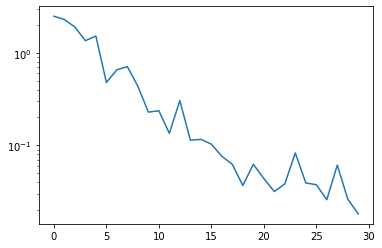

In [60]:
plt.yscale("log")
plt.plot(train_losses, label='training loss')
#plt.savefig('8 words training losses lr=0,001, bs=2')

In [61]:
#torch.save(CNN_model.state_dict(), 'CNN_model_8_words_batch.pt')
#torch.save(Encoder_model.state_dict(), 'Encoder_model_8_words_batch.pt')
#torch.save(Decoder_model.state_dict(), 'Decoder_model_8_words_batch.pt')

In [74]:
topv, topi = decoder_output.topk(1)
topi.squeeze().detach()

tensor(1, device='cuda:0')

In [88]:
from torch.nn.utils.rnn import pack_sequence
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
a = torch.tensor([1,2,3])
b = torch.tensor([4,5])
c = torch.tensor([6])
packed = pack_sequence([a, b, c])
print(packed)
seq_unpacked, lens_unpacked = pad_packed_sequence(packed, batch_first=True)
print(seq_unpacked)

PackedSequence(data=tensor([1, 4, 6, 2, 5, 3]), batch_sizes=tensor([3, 2, 1]), sorted_indices=None, unsorted_indices=None)
tensor([[1, 2, 3],
        [4, 5, 0],
        [6, 0, 0]])


In [92]:
a[:-1]
a[1:]

torch.Size([1])
